Predict Stock Prices 5 Days Ahead

In [26]:
import yfinance as yf

data = yf.download('PLTR', period='1y')

close_price = data['Close']
print(close_price)



[*********************100%***********************]  1 of 1 completed

Ticker            PLTR
Date                  
2024-05-01   22.120001
2024-05-02   22.549999
2024-05-03   23.330000
2024-05-06   25.209999
2024-05-07   21.400000
...                ...
2025-04-24  107.779999
2025-04-25  112.779999
2025-04-28  114.650002
2025-04-29  116.080002
2025-04-30  118.440002

[250 rows x 1 columns]


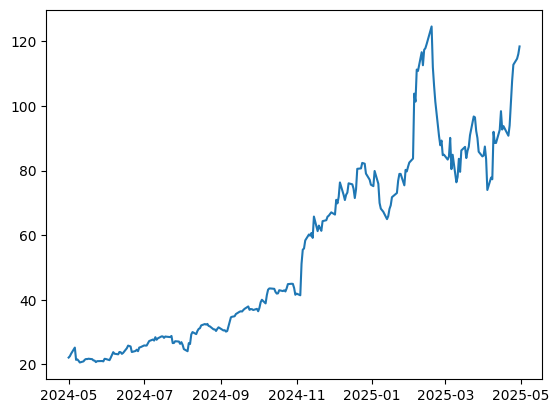

In [27]:
import matplotlib.pyplot as plt

plt.plot(close_price)
plt.show()

In [28]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

data = close_price.to_numpy()

scaler = MinMaxScaler()
scaled_dataset = scaler.fit_transform(data)


train_size = int(len(scaled_dataset) * 0.70)
train_set = scaled_dataset[:train_size]
test_set = scaled_dataset[train_size:]

def create_sequence(data, seq_length, n_steps_ahead):
    x = []
    y = []
    for i in range(seq_length, len(data) - n_steps_ahead + 1):
        x.append(data[i-seq_length:i, 0])
        y.append(data[i:i+n_steps_ahead, 0])
    
    return np.array(x), np.array(y)

x_train, y_train = create_sequence(train_set, 60, 5)
x_test, y_test = create_sequence(test_set, 60, 5)

# (samples, time_steps, features)
x_train = x_train.reshape((x_train.shape[0],x_train.shape[1],1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

In [ ]:
import torch 
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam 

x_train_tensor = torch.from_numpy(x_train).float()
y_train_tensor = torch.from_numpy(y_train).float()

dataset = TensorDataset(x_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, shuffle=True)

class LSTM(nn.Module):
    
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        
        super().__init__()
        
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 5)

    def forward(self, input):
        h0 = torch.zeros(self.num_layers, input.size(0), self.hidden_size).to(input.device)
        c0 = torch.zeros(self.num_layers, input.size(0), self.hidden_size).to(input.device)
        
        out, _ = self.lstm(input, (h0, c0))
        
        out = self.fc(out[:, -1, :])
        
        return out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTM().to(device)
loss_func = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.01)
        


max_epochs = 100
for epoch in range(max_epochs):
    model.train()
    epoch_loss = 0 
    
    for x_batch, y_batch in dataloader:
        
        optimizer.zero_grad()
        
        output = model(x_batch)
        
        loss = loss_func(output, y_batch)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {epoch_loss:.4f}")
    

x_test_tensor = torch.from_numpy(x_test).float()
y_test_tensor = torch.from_numpy(y_test).float()


model.eval()

with torch.no_grad():
    prediction = model(x_test_tensor)
    predicted_price = prediction.detach().numpy()
    predicted = scaler.inverse_transform(predicted_price)
    


print(predicted[-1])
    

Epoch 0, Loss: 3.8441
Epoch 10, Loss: 0.1831
Epoch 20, Loss: 0.1822
Epoch 30, Loss: 0.1634
Epoch 40, Loss: 0.1417
Epoch 50, Loss: 0.1453
Epoch 60, Loss: 0.1353
Epoch 70, Loss: 0.1546
Epoch 80, Loss: 0.1846
Epoch 90, Loss: 0.1325
[85.17861  82.49954  80.50998  77.756035 77.08832 ]


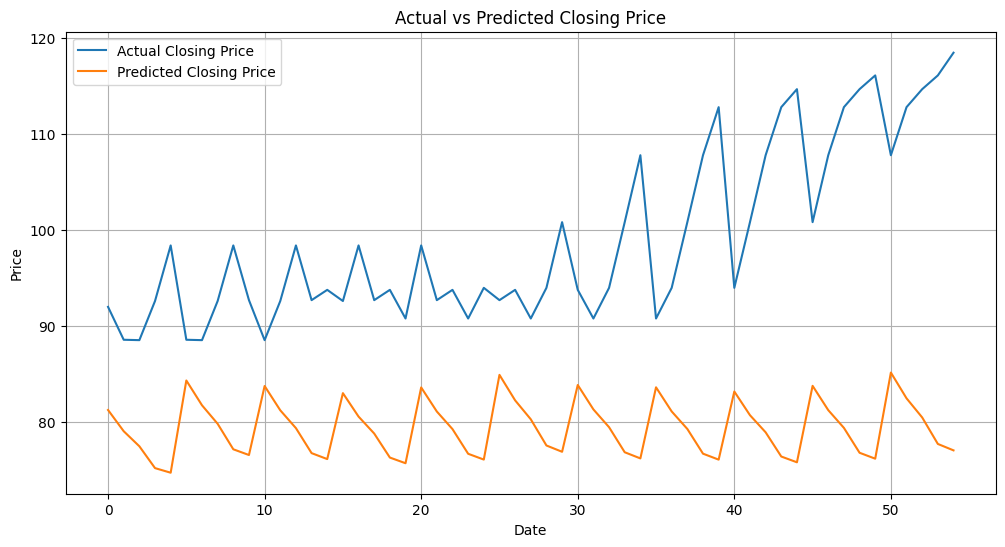

In [ ]:
true_prices = scaler.inverse_transform(y_test.reshape(-1,1))

true_prices = true_prices.flatten()
predicted = predicted.flatten()


# Plot
plt.figure(figsize=(12, 6))
plt.plot(true_prices, label='Actual Closing Price')
plt.plot(predicted, label='Predicted Closing Price')
plt.title('Actual vs Predicted Closing Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()